# Notebook to plot Orca Calls from Hydrophone data

This notebook uses python to read hydrophone data provided by https://github.com/orcasound/orcadata/wiki and start exploring the feature space of the data that will help us build a detection/classification system.

Made (shamelessly) by Marine Denolle (mdenolle@uw.edu) 2/16/24



Intermediate signal:noise ratio
05 Jul 2019 -- 1/2 hour of data from the Orcasound Lab node labeled in Audacity by Scott
Labels:
only calls
AWS CLI access via aws --no-sign-request s3 cp s3://acoustic-sandbox/labeled-data/classification/killer-whales/southern-residents/20190705/orcasound-lab/test-only/OS_7_05_2019_08_24_00_labels-SV_200210_only_calls.txt .
other signals -- with start/end times + label in row N ("call," specific stereotyped call ID, or "?" to indicate probable but not 100% certain call); row N+1 starts with \ and then contains lower and upper frequency bounds.
AWS CLI access via aws --no-sign-request s3 cp s3://acoustic-sandbox/labeled-data/classification/killer-whales/southern-residents/20190705/orcasound-lab/test-only/OS_7_05_2019_08_24_00_labels-SV_200210_other_signals.txt .
Audio data -- in WAV format
AWS CLI access via aws --no-sign-request s3 cp s3://acoustic-sandbox/labeled-data/classification/killer-whales/southern-residents/20190705/orcasound-lab/test-only/OS_7_05_2019_08_24_00_.wav .
Metadata

In [1]:
# !pip install librosa
# !pip freeze > requirements.txt

In [40]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import obspy
import pandas as pd

In [41]:
# Load the audio file
audio_path = './data/OS_7_05_2019_08_24_00_.wav'
y, sr = librosa.load(audio_path) # data, sampling rate
print(sr)

22050


In [8]:
# create a time vector
t = np.linspace(0,y.shape[0]/sr,y.shape[0])
print(t[0],t[-1])

0.0 1800.16


## Plot data



Text(0, 0.5, 'Mysterious unit')

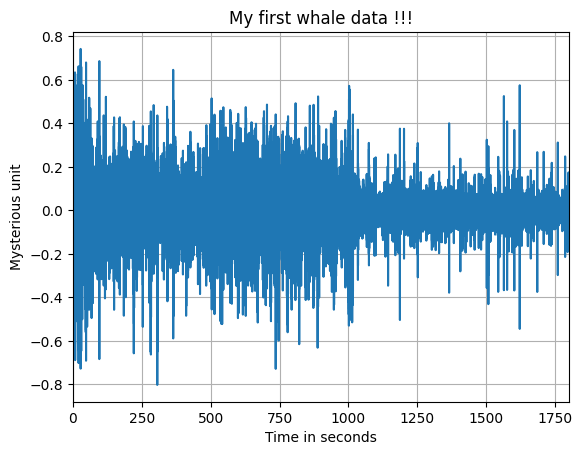

In [9]:
plt.plot(t,y);plt.xlabel('Time in seconds')
plt.grid(True)
plt.title('My first whale data !!!')
plt.xlim([t[0],t[-1]])
plt.ylabel('Mysterious unit')

## FFT to get the harmonics

In [14]:
def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()


In [11]:
n_fft = y.shape[0] #next_power_of_2(y.shape[0])
freqs = np.fft.rfftfreq(n_fft, d=1/sr)
fft_result = np.fft.rfft(y,n_fft)
print(fft_result.shape,freqs.shape)

(19846765,) (19846765,)


In [12]:
freqs

array([0.00000000e+00, 5.55506177e-04, 1.11101235e-03, ...,
       1.10249989e+04, 1.10249994e+04, 1.10250000e+04])

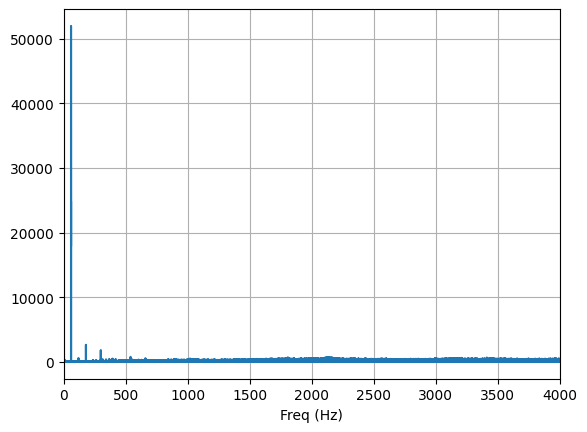

In [13]:
plt.plot(freqs,np.abs(fft_result))
plt.xlabel('Freq (Hz)');plt.xlim([0,4000])
plt.grid(True)

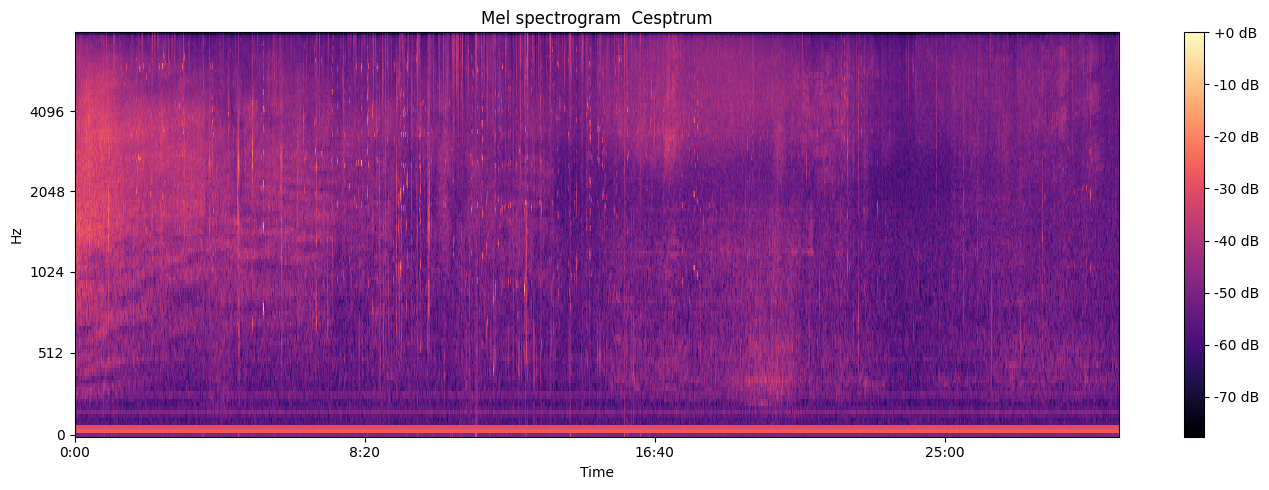

In [15]:

# Create the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
# Convert to decibels
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram  Cesptrum')
plt.tight_layout()
plt.show()


## Detect the orca with conventional seismology



In [19]:
import obspy.signal.trigger
F_max = 1600 # Hz

st_window = 3/F_max # short window in seconds
lt_window = 100/F_max # long window in seconds


crap = obspy.signal.trigger.recursive_sta_lta(y,int(sr*st_window),int(sr*lt_window))

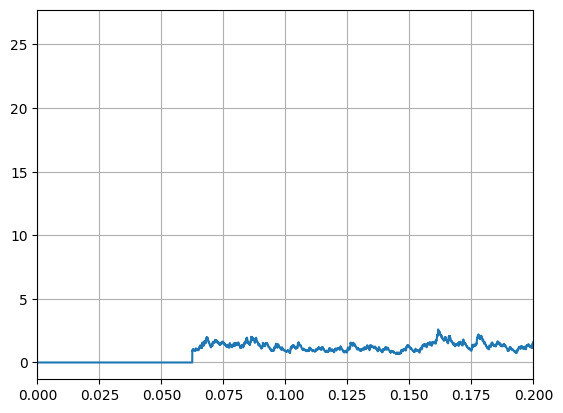

In [20]:
plt.plot(t,crap);plt.xlim([0,0.2]);plt.grid()

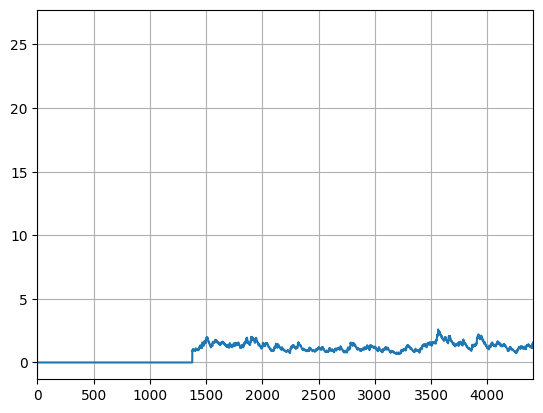

In [21]:
plt.plot(crap);plt.xlim([0,int(0.2*sr)]);plt.grid()

In [22]:
ik = np.where(crap>5)[0]
print(ik)

[   19132    19133    19134 ... 39675433 39675434 39675435]


[1 1 1 ... 1 1 1]


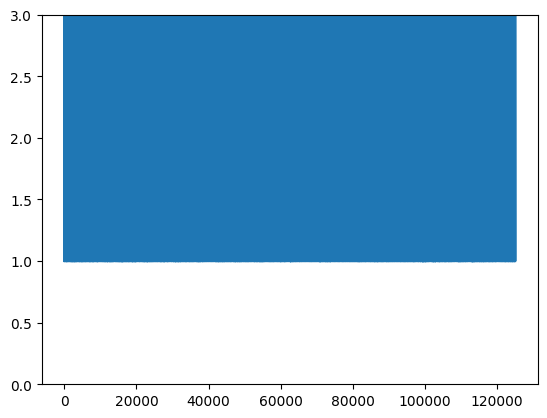

In [23]:
# plt.plot(ik[1:]-ik[:-1],'.')
ik2=np.diff(ik)
plt.plot(ik2)
plt.ylim([0,3])
print(ik2)

In [24]:
print(ik)

[   19132    19133    19134 ... 39675433 39675434 39675435]


In [30]:
print(ik2)

[1 1 1 ... 1 1 1]


In [31]:
ik3 = np.where(ik2>4)[0]
ik3 += 1
print(ik3)

[     5     26     59 ... 124977 125017 125025]


In [32]:
ik_final = ik[ik3]
print(ik_final)

[   37536    57010    59768 ... 39665035 39671134 39675420]


In [33]:
t_detect = ik_final/sr
print(t_detect)

[1.70231293e+00 2.58548753e+00 2.71056689e+00 ... 1.79886780e+03
 1.79914440e+03 1.79933878e+03]


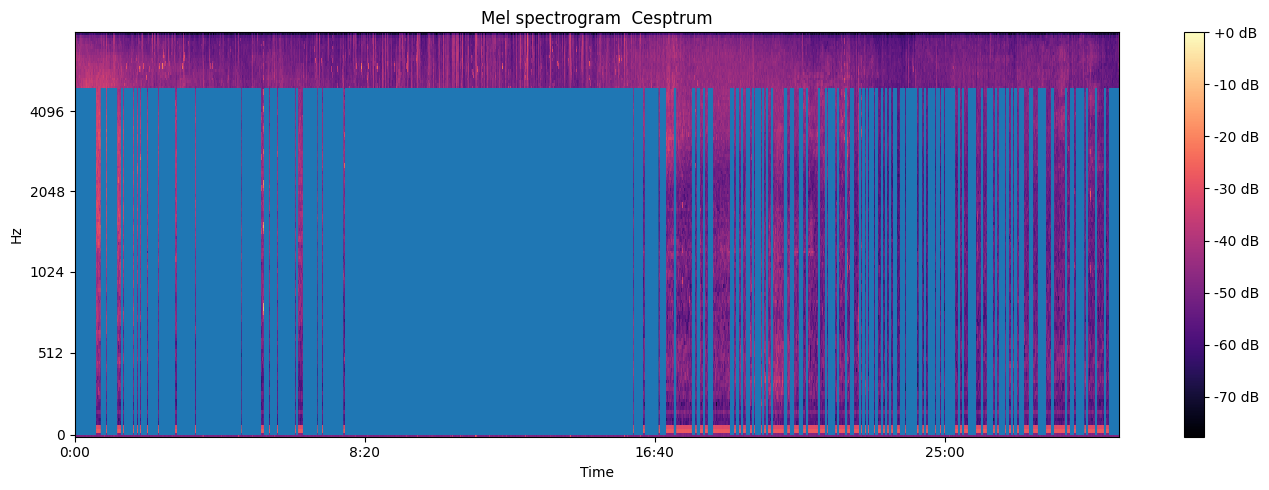

In [34]:
# Create the spectrogram
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
# Convert to decibels
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
# Plot the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.vlines(t_detect,0,5000)
plt.title('Mel spectrogram  Cesptrum')
plt.tight_layout()
plt.show()

In [35]:
df = pd.DataFrame({'times': t_detect, 'indices': ik_final})
df = df.set_index('times')
print(df)

              indices
times                
1.702313        37536
2.585488        57010
2.710567        59768
3.377460        74473
3.730748        82263
...               ...
1797.993107  39645748
1797.997914  39645854
1798.867800  39665035
1799.144399  39671134
1799.338776  39675420

[3378 rows x 1 columns]


In [36]:
df.to_csv('data/output_file.csv', index=False)